# Experimen 1

In [3]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

# set BASE_DIR = root project (bukan folder notebooks)
BASE_DIR = Path("..").resolve()
DATA_PROC = BASE_DIR / "data" / "processed"

print("CWD       :", os.getcwd())
print("BASE_DIR  :", BASE_DIR)
print("DATA_PROC :", DATA_PROC)

# tambahkan root project ke sys.path kalau belum ada
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))
    print(">> BASE_DIR ditambahkan ke sys.path")

# setelah ini baru boleh import src.*
from src.fuzzy_system import hitung_resiko_hoaks  # fuzzy baseline


CWD       : c:\Kuliah ITS Farhan\Semester 3\A_Final_Project\FP_KK\fp_kk_11_early_warning_hoax\notebooks
BASE_DIR  : C:\Kuliah ITS Farhan\Semester 3\A_Final_Project\FP_KK\fp_kk_11_early_warning_hoax
DATA_PROC : C:\Kuliah ITS Farhan\Semester 3\A_Final_Project\FP_KK\fp_kk_11_early_warning_hoax\data\processed
>> BASE_DIR ditambahkan ke sys.path


In [4]:
# load dataset 30 yang sudah ada skor LLM
path_multi_llm = DATA_PROC / "hoax_dataset_llm_multimodal.csv"
df30 = pd.read_csv(path_multi_llm).reset_index(drop=True)

print("Shape :", df30.shape)
print("Kolom :", list(df30.columns))

# label manual berdasarkan indeks:
# index 0–13  -> hoax (100)
# index 14–29 -> valid (0)
df30["label_resiko_hoaks"] = df30.index.map(lambda i: 100 if i < 14 else 0)

# untuk referensi: klas hoax/valid biner (1 = hoax, 0 = valid)
df30["label_hoax_bin"] = (df30["label_resiko_hoaks"] >= 50).astype(int)

df30[["text", "label_resiko_hoaks", "label_hoax_bin"]].head(10)


Shape : (30, 8)
Kolom : ['id', 'text', 'file_postingan', 'file_profil', 'intensitas_emosi', 'kecurigaan_format', 'kredibilitas_rendah', 'resiko_hoaks']


,text,label_resiko_hoaks,label_hoax_bin
0,PAK JOKOWI RUNTUHKAN RENCANA LICIK SBY PRESIDE...,100,1
1,"💥💥Prabowo Minta Kejagung Usut,.. Total Kekayaa...",100,1
2,Secara mengejutkan Ali Mochtar Ngabalin sebut ...,100,1
3,TERBONGKAR SKANDAL DANA GELAP PUAN MAHARANI VI...,100,1
4,"EKONOMI T3RANC4M, N3GAR-SUNT1K Rp 901 T KE RAK...",100,1
5,PRESIDEN BACAKAN NOTA PENCOPOTAN AHY ! AGENDA ...,100,1
6,PRESIDEN PRABOWO PECAT MENTERI PEMBANGKANG ! D...,100,1
7,PRESIDEN PRABOWO PECAT AHY DENGAN TIDAK HORMAT...,100,1
8,“JANGAN DISKIP YA REZEKI TIDAK DATANG DUA KALI...,100,1
9,Ribuan pendeta buang alquran ke sungai gangga,100,1


In [5]:
# pastikan nama kolom skor LLM sama:
# intensitas_emosi, kecurigaan_format, kredibilitas_rendah
required_cols = ["intensitas_emosi", "kecurigaan_format", "kredibilitas_rendah"]
for c in required_cols:
    if c not in df30.columns:
        raise KeyError(f"Kolom '{c}' tidak ditemukan di df30!")

def fuzzy_baseline_row(row):
    return hitung_resiko_hoaks(
        intensitas_emosi=row["intensitas_emosi"],
        kecurigaan_format=row["kecurigaan_format"],
        kredibilitas_rendah=row["kredibilitas_rendah"],
        output_scale_100=True,
    )

df30["resiko_hoaks_fuzzy"] = df30.apply(fuzzy_baseline_row, axis=1)

df30[["text", "label_resiko_hoaks", "resiko_hoaks_fuzzy"]].head(10)


,text,label_resiko_hoaks,resiko_hoaks_fuzzy
0,PAK JOKOWI RUNTUHKAN RENCANA LICIK SBY PRESIDE...,100,84.574380
1,"💥💥Prabowo Minta Kejagung Usut,.. Total Kekayaa...",100,84.574380
2,Secara mengejutkan Ali Mochtar Ngabalin sebut ...,100,83.238693
3,TERBONGKAR SKANDAL DANA GELAP PUAN MAHARANI VI...,100,84.574380
4,"EKONOMI T3RANC4M, N3GAR-SUNT1K Rp 901 T KE RAK...",100,83.238693
5,PRESIDEN BACAKAN NOTA PENCOPOTAN AHY ! AGENDA ...,100,84.574380
6,PRESIDEN PRABOWO PECAT MENTERI PEMBANGKANG ! D...,100,83.238693
7,PRESIDEN PRABOWO PECAT AHY DENGAN TIDAK HORMAT...,100,84.574380
8,“JANGAN DISKIP YA REZEKI TIDAK DATANG DUA KALI...,100,84.574380
9,Ribuan pendeta buang alquran ke sungai gangga,100,84.574380


In [6]:
y_true = df30["label_resiko_hoaks"].values        # 0 atau 100
y_pred = df30["resiko_hoaks_fuzzy"].values        # 0–100

# MAE (regresi)
mae = np.mean(np.abs(y_pred - y_true))

# klasifikasi: threshold 50
true_cls = (y_true >= 50).astype(int)   # 1=hoax, 0=valid
pred_cls = (y_pred >= 50).astype(int)

accuracy = (true_cls == pred_cls).mean()

tp = np.sum((true_cls == 1) & (pred_cls == 1))
tn = np.sum((true_cls == 0) & (pred_cls == 0))
fp = np.sum((true_cls == 0) & (pred_cls == 1))
fn = np.sum((true_cls == 1) & (pred_cls == 0))

print(f"MAE Fuzzy (dataset 30) : {mae:.4f}")
print(f"Akurasi klasifikasi    : {accuracy*100:.2f}%")
print("Confusion matrix (true x pred, 1=hoax,0=valid)")
print(f"TP={tp}, FN={fn}, FP={fp}, TN={tn}")


MAE Fuzzy (dataset 30) : 11.6477
Akurasi klasifikasi    : 96.67%
Confusion matrix (true x pred, 1=hoax,0=valid)
TP=14, FN=0, FP=1, TN=15


In [9]:
summary_exp1 = pd.DataFrame(
    {
        "Model": ["Fuzzy"],
        "MAE terhadap label_resiko_hoaks": [mae],
        "Akurasi klasifikasi (%)": [accuracy * 100],
        "TP": [tp],
        "FN": [fn],
        "FP": [fp],
        "TN": [tn],
    }
)

summary_exp1


,Model,MAE terhadap label_resiko_hoaks,Akurasi klasifikasi (%),TP,FN,FP,TN
0,Fuzzy,11.647744,96.666667,14,0,1,15


# Eksperimen 2

In [4]:
path_sample100 = DATA_PROC / "hoax_umpo_sample_100_llm.csv"
df100 = pd.read_csv(path_sample100)


NameError: name 'DATA_PROC' is not defined

In [11]:
from src.fuzzy_system import hitung_resiko_hoaks, hitung_resiko_hoaks_pso

df100["resiko_fuzzy"] = df100.apply(
    lambda row: hitung_resiko_hoaks(
        intensitas_emosi=row["intensitas_emosi"],
        kecurigaan_format=row["kecurigaan_format"],
        kredibilitas_rendah=row["kredibilitas_rendah"],
        output_scale_100=True,
    ),
    axis=1,
)


In [12]:
df100["resiko_pso"] = df100.apply(
    lambda row: hitung_resiko_hoaks_pso(
        intensitas_emosi=row["intensitas_emosi"],
        kecurigaan_format=row["kecurigaan_format"],
        kredibilitas_rendah=row["kredibilitas_rendah"],
        output_scale_100=True,
    ),
    axis=1,
)


In [13]:
y_true = df100["label_resiko_hoaks"].values

def eval_model(y_pred):
    mae = np.mean(np.abs(y_pred - y_true))

    true_cls = (y_true >= 50).astype(int)
    pred_cls = (y_pred >= 50).astype(int)

    acc = (true_cls == pred_cls).mean()
    tp = np.sum((true_cls == 1) & (pred_cls == 1))
    tn = np.sum((true_cls == 0) & (pred_cls == 0))
    fp = np.sum((true_cls == 0) & (pred_cls == 1))
    fn = np.sum((true_cls == 1) & (pred_cls == 0))

    return mae, acc, tp, fn, fp, tn

mae_fuzzy, acc_fuzzy, tp_f, fn_f, fp_f, tn_f = eval_model(df100["resiko_fuzzy"].values)
mae_pso, acc_pso, tp_p, fn_p, fp_p, tn_p = eval_model(df100["resiko_pso"].values)


In [14]:
summary_exp2 = pd.DataFrame(
    {
        "Model": ["Fuzzy saja", "Fuzzy + PSO"],
        "MAE": [mae_fuzzy, mae_pso],
        "Akurasi (%)": [acc_fuzzy * 100, acc_pso * 100],
        "TP": [tp_f, tp_p],
        "FN": [fn_f, fn_p],
        "FP": [fp_f, fp_p],
        "TN": [tn_f, tn_p],
    }
)

summary_exp2


,Model,MAE,Akurasi (%),TP,FN,FP,TN
0,Fuzzy saja,37.171572,69.0,32,18,13,37
1,Fuzzy + PSO,40.148380,66.0,25,25,9,41


# Experiment 3


In [9]:
import os
import sys
from pathlib import Path

# posisi notebook ada di folder "notebooks"
ROOT_DIR = Path("..").resolve()   # naik satu level → folder project
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

print("ROOT_DIR :", ROOT_DIR)
print("Isi ROOT_DIR :", os.listdir(ROOT_DIR))


ROOT_DIR : C:\Kuliah ITS Farhan\Semester 3\A_Final_Project\FP_KK\fp_kk_11_early_warning_hoax
Isi ROOT_DIR : ['.env', '.git', '.gitignore', '.venv', 'app', 'data', 'notebooks', 'README.md', 'requirements.txt', 'src']


In [10]:
import numpy as np
import pandas as pd

from src.fuzzy_system import (
    hitung_resiko_hoaks,
    hitung_resiko_hoaks_pso,
)

from src.pso_optimizer import BEST_W_PSO


In [11]:
def fuzzy_only(emosi, fmt, kred):
    return hitung_resiko_hoaks(
        intensitas_emosi=emosi,
        kecurigaan_format=fmt,
        kredibilitas_rendah=kred,
        output_scale_100=True,
    )

def fuzzy_pso(emosi, fmt, kred, w=BEST_W_PSO):
    return hitung_resiko_hoaks_pso(
        intensitas_emosi=emosi,
        kecurigaan_format=fmt,
        kredibilitas_rendah=kred,
        weights=w,
        output_scale_100=True,
    )


In [14]:
def sensitivity_one_var(var_name, fixed_1, fixed_2, use_pso=False):
    """
    var_name : 'emosi' / 'format' / 'kred'
    fixed_1  : nilai tetap variabel ke-2
    fixed_2  : nilai tetap variabel ke-3
    """
    xs = np.linspace(0.0, 1.0, 21)  # 0.0, 0.05, ..., 1.0
    outputs = []

    for x in xs:
        if var_name == "emosi":
            emosi, fmt, kred = x, fixed_1, fixed_2
        elif var_name == "format":
            emosi, fmt, kred = fixed_1, x, fixed_2
        else:  # "kred"
            emosi, fmt, kred = fixed_1, fixed_2, x

        if use_pso:
            y = fuzzy_pso(emosi, fmt, kred)
        else:
            y = fuzzy_only(emosi, fmt, kred)

        outputs.append(y)

    df = pd.DataFrame({
        var_name: xs,
        "resiko_hoaks": outputs,
        "fixed_1": fixed_1,
        "fixed_2": fixed_2,
        "model": "Fuzzy+PSO" if use_pso else "Fuzzy",
    })
    return df


In [15]:
levels = [0.2, 0.5, 0.8]  # rendah, sedang, tinggi

dfs_emosi = []
for fmt in levels:
    for kred in levels:
        df_tmp = sensitivity_one_var(
            var_name="emosi",
            fixed_1=fmt,
            fixed_2=kred,
            use_pso=False,
        )
        dfs_emosi.append(df_tmp)

df_emosi = pd.concat(dfs_emosi, ignore_index=True)
df_emosi.head()


,emosi,resiko_hoaks,fixed_1,fixed_2,model
0,0.00,15.42562,0.2,0.2,Fuzzy
1,0.05,15.42562,0.2,0.2,Fuzzy
2,0.10,15.42562,0.2,0.2,Fuzzy
3,0.15,15.42562,0.2,0.2,Fuzzy
4,0.20,15.42562,0.2,0.2,Fuzzy


In [17]:
dfs_emosi_pso = []
for fmt in levels:
    for kred in levels:
        df_tmp = sensitivity_one_var(
            var_name="emosi",
            fixed_1=fmt,
            fixed_2=kred,
            use_pso=True,
        )
        dfs_emosi_pso.append(df_tmp)

df_emosi_pso = pd.concat(dfs_emosi_pso, ignore_index=True)


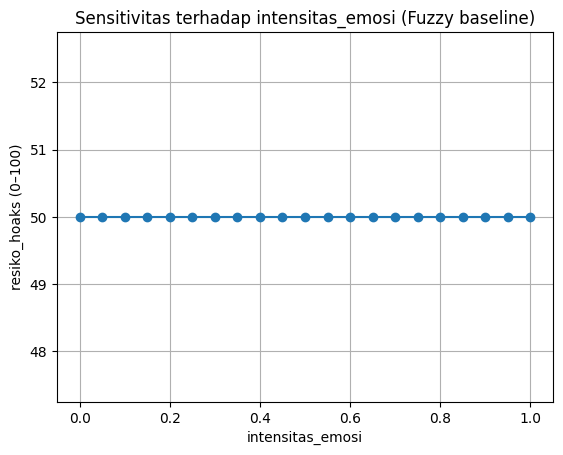

In [18]:
import matplotlib.pyplot as plt

df_plot = sensitivity_one_var("emosi", fixed_1=0.5, fixed_2=0.5, use_pso=False)

plt.figure()
plt.plot(df_plot["emosi"], df_plot["resiko_hoaks"], marker="o")
plt.xlabel("intensitas_emosi")
plt.ylabel("resiko_hoaks (0–100)")
plt.title("Sensitivitas terhadap intensitas_emosi (Fuzzy baseline)")
plt.grid(True)
plt.show()
